In [294]:
import os
import glob
import math
from math import pi
import sys
import random

sys.path.append("../scripts/")
sys.path.append("../src/")

import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.stats import entropy

import torch
from torch import nn
import torch.nn.functional as F

import mdshare 
import mdtraj as md 
from ase import Atoms
import nglview as ng
from nglview import show_ase

import pyemma
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt

In [591]:
def get_atomNum(traj):
    
    atomic_nums = [atom.element.number for atom in traj.top.atoms]
    
    protein_index = traj.top.select("protein")
    protein_top = traj.top.subset(protein_index)

    atomic_nums = [atom.element.number for atom in protein_top.atoms]
    
    return np.array(atomic_nums), protein_index

### Load chignolin dataset and analyze

In [3]:
traj_files = glob.glob('../data/filtered/e1*/*.xtc')
pdb_file = md.load_pdb('../data/filtered/filtered.pdb')

In [5]:
all_traj = [md.load_xtc(file, top='../data/filtered/filtered.pdb') for file in traj_files]
all_traj = md.join(all_traj)

In [6]:
# Featurize trajectories
features = coor.featurizer(pdb_file)
features.add_residue_mindist()

19-09-22 12:56:12 pyemma.coordinates.data.featurization.featurizer.MDFeaturizer[0] WARNING  Using all residue pairs with schemes like closest or closest-heavy is very time consuming. Consider reducing the residue pairs


In [7]:
source = pyemma.coordinates.source([traj_files], features=features, chunk_size=10000)
source

/tmp/ipykernel_31738/2116856025.py:1: PyEMMA_DeprecationWarning: Passed deprecated argument "chunk_size", please use "chunksize"
  source = pyemma.coordinates.source([traj_files], features=features, chunk_size=10000)


In [8]:
# Perform TICA
tica_obj = pyemma.coordinates.tica(data=source, lag=5, dim=10)
tica = tica_obj.get_output()[0]

Text(-0.5, 1, '3')

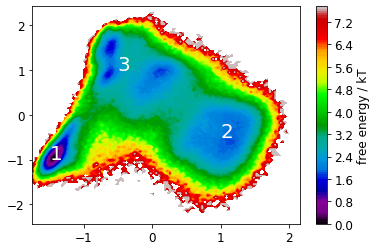

In [9]:
# Plot first two dimensions
xall = np.vstack(tica)[:,0]
yall = np.vstack(tica)[:,1]
plt.rcParams.update({'font.size': 12})
mplt.plot_free_energy(xall, yall)
ax = plt.gca()
ax.text(-1.5, -1, '1', fontsize=20, color='white')
ax.text(1, -0.5, '2', fontsize=20, color='white')
ax.text(-0.5, 1, '3', fontsize=20, color='white')

### Load pentapeptide dataset and analyze

In [11]:
traj_files = glob.glob('../data/penta*.xtc')
penta_traj = [md.load_xtc(file, top='../data/pentapeptide-impl-solv.pdb') for file in traj_files]

In [12]:
# Featurize trajectories
pdb_file = md.load_pdb('../data/pentapeptide-impl-solv.pdb')
penta_features = coor.featurizer(pdb_file)
penta_features.add_residue_mindist()
penta_source = pyemma.coordinates.source([traj_files], features=penta_features, chunk_size=10000)

19-09-22 12:58:51 pyemma.coordinates.data.featurization.featurizer.MDFeaturizer[4] WARNING  Using all residue pairs with schemes like closest or closest-heavy is very time consuming. Consider reducing the residue pairs


/tmp/ipykernel_31738/275821638.py:5: PyEMMA_DeprecationWarning: Passed deprecated argument "chunk_size", please use "chunksize"
  penta_source = pyemma.coordinates.source([traj_files], features=penta_features, chunk_size=10000)


In [19]:
# Perform TICA
penta_tica_obj = pyemma.coordinates.tica(data=penta_source, lag=5, dim=3)
penta_tica = penta_tica_obj.get_output()[0]

Text(-0.5, 1, '3')

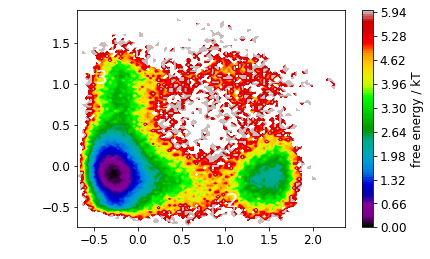

In [20]:
# Plot first two dimensions
xall = np.vstack(penta_tica)[:,0]
yall = np.vstack(penta_tica)[:,1]
plt.rcParams.update({'font.size': 12})
mplt.plot_free_energy(xall, yall)
ax = plt.gca()
ax.text(-1.5, -1, '1', fontsize=20, color='white')
ax.text(1, -0.5, '2', fontsize=20, color='white')
ax.text(-0.5, 1, '3', fontsize=20, color='white')

In [179]:
penta_all_traj = md.join(penta_traj)

In [182]:
penta_all_traj

<mdtraj.Trajectory with 125025 frames, 94 atoms, 5 residues, and unitcells at 0x7f03b0d7ca60>

In [181]:
len(tica)

594495

In [184]:
penta_fold_traj = penta_all_traj[(-0.6<penta_tica[:,0]) & (penta_tica[:,0]<-0.1) & (penta_tica[:,1]<0.25) & (-0.25<penta_tica[:,1])] 

In [187]:
v = view_traj(penta_fold_traj[200])
v.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### Fs

In [ ]:
traj_files = glob.glob('../data/penta*.xtc')
penta_traj = [md.load_xtc(file, top='../data/pentapeptide-impl-solv.pdb') for file in traj_files]

In [575]:
traj_files = glob.glob('../data/nucleocapsid/all_nucleocapsid.xtc')
nuc_traj = [md.load_xtc(file, top='../data/nucleocapsid/onlyprot.pdb') for file in traj_files]

In [581]:
nuc_traj[0][0]

<mdtraj.Trajectory with 1 frames, 812 atoms, 53 residues, without unitcells at 0x7f0195b49670>

In [582]:
nuc_results = load_test_results_only('nucleocapsid_09-19_alpha_sample_ndata5000_N5_test_nucleocapsid', nuc_traj[0][0].top)

In [584]:
nt, nb = nuc_results['true_traj'].top.to_dataframe()
nt

,serial,name,element,resSeq,resName,chainID,segmentID
0,7,N,N,2,PHE,0,
1,8,CA,C,2,PHE,0,
2,9,C,C,2,PHE,0,
3,10,O,O,2,PHE,0,
4,11,H,H,2,PHE,0,
...,...,...,...,...,...,...,...
807,814,OE2,O,54,GLU,0,
808,815,HB3,H,54,GLU,0,
809,816,HB2,H,54,GLU,0,
810,817,HG3,H,54,GLU,0,


In [585]:
nt.loc[nt['resSeq']==8]

,serial,name,element,resSeq,resName,chainID,segmentID
93,100,N,N,8,ALA,0,
94,101,CA,C,8,ALA,0,
95,102,C,C,8,ALA,0,
96,103,O,O,8,ALA,0,
97,104,H,H,8,ALA,0,
98,105,HA,H,8,ALA,0,
99,106,CB,C,8,ALA,0,
100,107,HB1,H,8,ALA,0,
101,108,HB2,H,8,ALA,0,
102,109,HB3,H,8,ALA,0,


In [ ]:
# Featurize trajectories
pdb_file = md.load_pdb('../data/nucleocapsid/onlyprot.pdb')
nuc_features = coor.featurizer(pdb_file)
nuc_features.add_residue_mindist()
nuc_source = pyemma.coordinates.source([traj_files], features=nuc_features, chunk_size=10000)

In [ ]:
# Perform TICA
nuc_tica_obj = pyemma.coordinates.tica(data=nuc_source, lag=5, dim=3)
nuc_tica = nuc_tica_obj.get_output()[0]

### OG model - chignolin 3

In [507]:
# ogchig
exp_path = './og_chig_from_eofe/fold0/chig_1_result'
ogchig1_results = load_test_results(exp_path, top, features, tica_obj)
exp_path = './og_chig_from_eofe/fold0/chig_2_result'
ogchig2_results = load_test_results(exp_path, top, features, tica_obj)
exp_path = './og_chig_from_eofe/fold0/chig_3_result'
ogchig3_results = load_test_results(exp_path, top, features, tica_obj)

In [392]:
print("In-class rmsd: ", chig3_results['rmsd'].mean())
print("Out-of-class rmsd: ", chig1_results['rmsd'].mean())

In-class rmsd:  0.24691164
Out-of-class rmsd:  0.29014403


In [393]:
all_results = combine_results([chig1_results, chig2_results, chig3_results])
# chig_recon_xyz, chig_true_xyz, chig_recon_red, chig_true_red, rmsd

/tmp/ipykernel_31738/3417305845.py:11: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


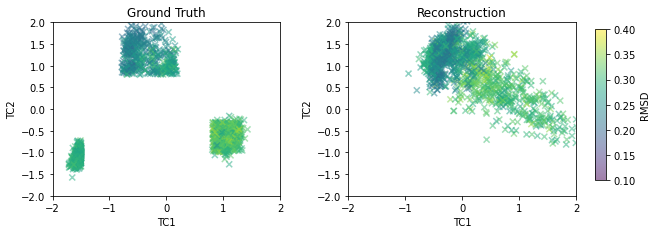

In [319]:
plot_results(all_results[2], all_results[3], all_results[4])

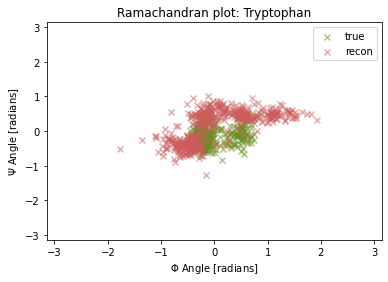

In [426]:
draw_ram(chig3_results['true_traj'], chig3_results['recon_traj'])

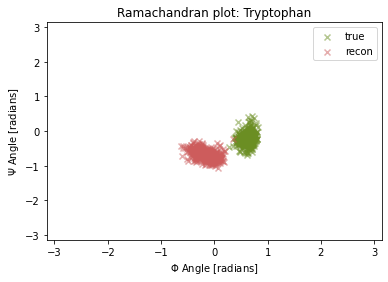

In [427]:
draw_ram(chig1_results['true_traj'], chig1_results['recon_traj'])

In [380]:
v = view_traj(chig1_results['recon_traj'][0])
v.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [533]:
v = view_traj(chig1_results['true_traj'][0])
v.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [536]:
m_view = ng.show_mdtraj(chig3_results['true_traj'][0].center_coordinates())
m_view

NGLWidget()

In [535]:
m_view = ng.show_mdtraj(chig1_results['true_traj'][0].center_coordinates())
m_view

NGLWidget()

In [537]:
# 84, 150
v = view_traj(chig3_results['true_traj'][0])
v.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [372]:
v = view_traj(chig3_results['recon_traj'][84])
v.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### Model: chignolin full - sanity check

In [546]:
# nucleo2penta
exp_path = './nucleocapsid_09-19_alpha_sample_ndata5000_N5_test_pentapeptide'
ptop = penta_traj[0].top
npenta_results = load_test_results(exp_path, ptop, penta_features, penta_tica_obj)

In [ ]:
# nucleo2nucleo
exp_path = './nucleocapsid_09-19_alpha_sample_ndata5000_N5_test_pentapeptide'
ptop = penta_traj[0].top
nn_results = load_test_results(exp_path, ptop, penta_features, penta_tica_obj)

In [592]:
# ogfullchig
exp_path = './chig_full_og_09-20_alpha_sample_ndata5000_N5_test_chignolin_1'
ogfchig1_results = load_test_results(exp_path, top, features, tica_obj)
exp_path = './chig_full_og_09-20_alpha_sample_ndata5000_N5_test_chignolin_2'
ogfchig2_results = load_test_results(exp_path, top, features, tica_obj)
exp_path = './chig_full_og_09-20_alpha_sample_ndata5000_N5_test_chignolin_3'
ogfchig3_results = load_test_results(exp_path, top, features, tica_obj)

In [593]:
all_results = combine_results([ogfchig1_results, ogfchig2_results, ogfchig3_results])
# chig_recon_xyz, chig_true_xyz, chig_recon_red, chig_true_red, rmsd

/tmp/ipykernel_31738/3417305845.py:11: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


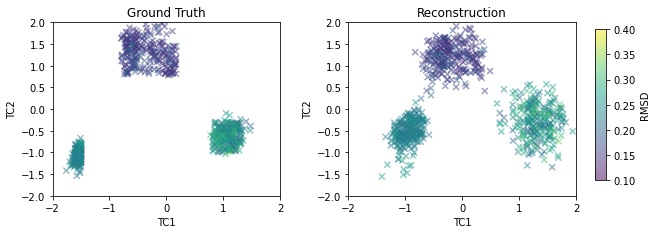

In [594]:
plot_results(all_results[2], all_results[3], all_results[4])

In [596]:
# fullchig
exp_path = './chig_multiCGVAE_09-16_alpha_sample_ndata5000_N10_test_chignolin_1'
chig1_results = load_test_results(exp_path, top, features, tica_obj)
exp_path = './chig_multiCGVAE_09-16_alpha_sample_ndata5000_N10_test_chignolin_2'
chig2_results = load_test_results(exp_path, top, features, tica_obj)
exp_path = './chig_multiCGVAE_09-16_alpha_sample_ndata5000_N10_test_chignolin_3'
chig3_results = load_test_results(exp_path, top, features, tica_obj)

In [385]:
print("In-class rmsd: ", chig3_results['rmsd'].mean())
print("Out-of-class rmsd: ", chig1_results['rmsd'].mean())

In-class rmsd:  0.15934399
Out-of-class rmsd:  0.24024515


In [598]:
all_results[4].mean()

0.2185317

In [597]:
all_results = combine_results([chig1_results, chig2_results, chig3_results])
# chig_recon_xyz, chig_true_xyz, chig_recon_red, chig_true_red, rmsd

/tmp/ipykernel_31738/3417305845.py:11: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


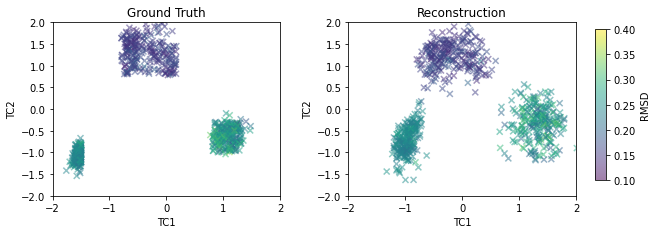

In [245]:
plot_results(all_results[2], all_results[3], all_results[4])

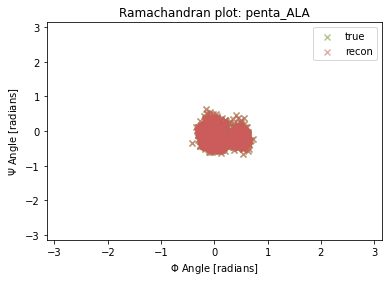

In [560]:
draw_ram(penta_traj[20], penta_traj[20], 'penta_ALA')

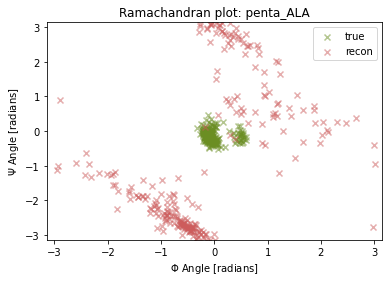

In [555]:
draw_ram(npenta_results['true_traj'], npenta_results['recon_traj'],'penta_ALA')

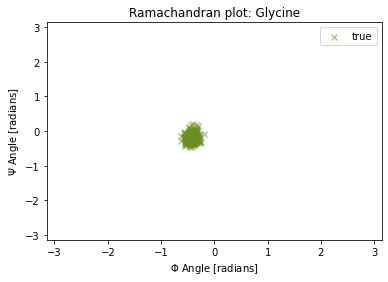

In [293]:
draw_ram(chig1_results['true_traj'],[])

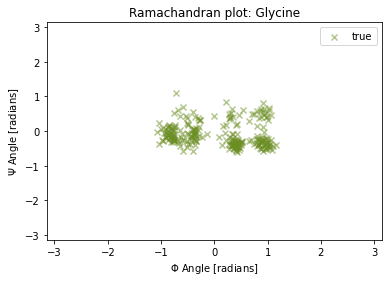

In [292]:
draw_ram(chig2_results['true_traj'],[])

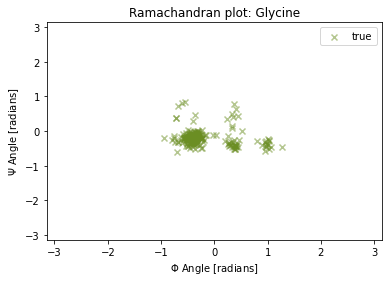

In [291]:
draw_ram(chig3_results['true_traj'],[])

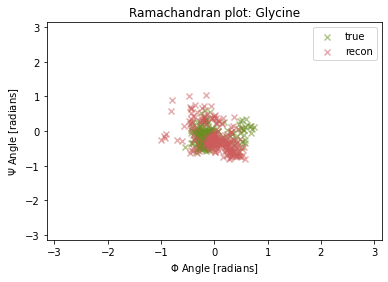

In [411]:
# TRP
draw_ram(chig3_results['true_traj'], chig3_results['recon_traj'])

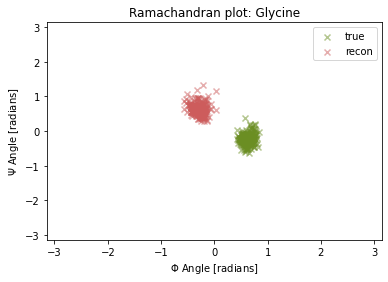

In [412]:
draw_ram(chig1_results['true_traj'], chig1_results['recon_traj'])

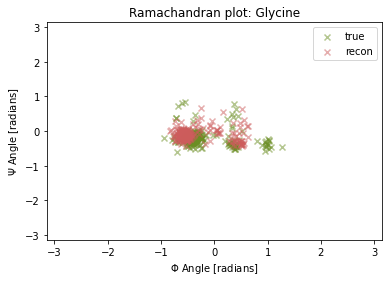

In [282]:
draw_ram(chig3_results['true_traj'], chig3_results['recon_traj'])

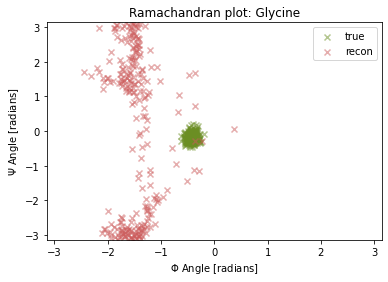

In [283]:
draw_ram(chig1_results['true_traj'], chig1_results['recon_traj'])

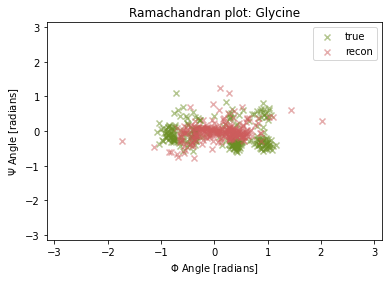

In [284]:
draw_ram(chig2_results['true_traj'], chig2_results['recon_traj'])

### chignolin state 3 - mode collapse check

**Train with chig partial, coil, penta. Test with chignolin**

In [599]:
# multitrain
exp_path = './chig_partial_3_coil_penta_09-17_alpha_sample_ndata5000_N5_test_chignolin_1/'
allchig1_results = load_test_results(exp_path, top, features, tica_obj)
exp_path = './chig_partial_3_coil_penta_09-17_alpha_sample_ndata5000_N5_test_chignolin_2'
allchig2_results = load_test_results(exp_path, top, features, tica_obj)
exp_path = './chig_partial_3_coil_penta_09-17_alpha_sample_ndata5000_N5_test_chignolin_3'
allchig3_results = load_test_results(exp_path, top, features, tica_obj)

In [248]:
print("In-class rmsd: ", chig3_results['rmsd'].mean())
print("Out-of-class rmsd: ", chig1_results['rmsd'].mean())

In-class rmsd:  0.14353421
Out-of-class rmsd:  0.23940507


In [602]:
all_results = combine_results([allchig1_results, allchig2_results, allchig3_results])

In [603]:
all_results[4].mean()

0.21663053

/tmp/ipykernel_31738/3417305845.py:11: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


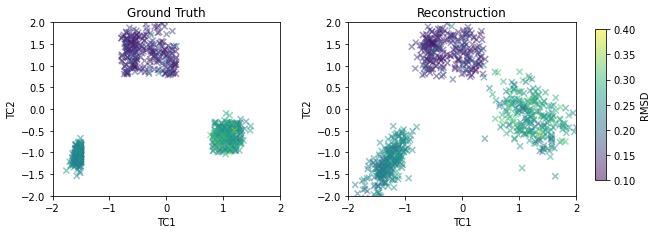

In [241]:
plot_results(all_results[2], all_results[3], all_results[4])

In [386]:
v = view_traj(chig1_results['true_traj'][0])
v.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [387]:
v = view_traj(chig1_results['recon_traj'][0])
v.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [388]:
v = view_traj(chig3_results['true_traj'][0])
v.show ()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [389]:
v = view_traj(chig3_results['recon_traj'][0])
v.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [147]:
set(list(table['resName']))

{'ASP', 'GLU', 'GLY', 'PRO', 'THR', 'TRP', 'TYR'}

In [464]:
bond

array([[  8.,  25.,   0.,   0.],
       [ 25.,  26.,   0.,   0.],
       [  8.,  10.,   0.,   0.],
       ...,
       [171., 172.,   0.,   0.],
       [171., 173.,   0.,   0.],
       [171., 174.,   0.,   0.]])

In [471]:
ls = [i+148 for i in range(27)]
ss = chig1_results['true_traj'][0].atom_slice(ls)
ss

<mdtraj.Trajectory with 1 frames, 27 atoms, 1 residues, without unitcells at 0x7f03b03bf3a0>

In [475]:
m_view = ng.show_mdtraj(ss.center_coordinates())
m_view

NGLWidget()

CG-CA-CB-N
34,29,31,27
C-O-CA-N
46,47,29,27

In [493]:
table.loc[table['resSeq']==2]

,serial,name,element,resSeq,resName,chainID,segmentID
27,28,N,N,2,TYR,0,P
28,29,H,H,2,TYR,0,P
29,30,CA,C,2,TYR,0,P
30,31,HA,H,2,TYR,0,P
31,32,CB,C,2,TYR,0,P
32,33,HB3,H,2,TYR,0,P
33,34,HB2,H,2,TYR,0,P
34,35,CG,C,2,TYR,0,P
35,36,CD1,C,2,TYR,0,P
36,37,HD1,H,2,TYR,0,P


phi N(i-1)-C(i)-CA(i)-N(i)
trp: 110, 146, 126, 124
gly: 89, 108, 105, 104
thr: 103, 122, 112, 110 
pro: 48, 72, 64, 60
asp: 27, 58, 50, 48
tyr: 6, 46, 29, 27
glu: 60, 87, 76, 74
penta_ala: 25, 52, 46, 44
penta_leu4: 44, 71, 56, 54
penta_leu2: 0,42,27,25
nuc_ala: 86, 95, 94, 93

psi C(i)-CA(i)-N(i)-C(i+1)
trp: 146, 126, 124, 167
gly: 108, 105, 104, 122
thr: 122, 112, 110, 146
pro: 72, 64, 60, 87
asp: 58, 50, 48, 72
tyr: 46, 29, 27, 58
glu: 87, 76, 74, 101
penta_ala: 52, 46, 44, 71
penta_leu4: 71, 56, 54,90
penta_leu2: 42,27,25,52
nuc_ala: 95, 94, 93, 105

In [588]:
nt.loc[nt['resSeq']==9]

,serial,name,element,resSeq,resName,chainID,segmentID
103,110,N,N,9,GLU,0,
104,111,CA,C,9,GLU,0,
105,112,C,C,9,GLU,0,
106,113,O,O,9,GLU,0,
107,114,H,H,9,GLU,0,
108,115,HA,H,9,GLU,0,
109,116,CB,C,9,GLU,0,
110,117,CG,C,9,GLU,0,
111,118,CD,C,9,GLU,0,
112,119,OE1,O,9,GLU,0,


In [136]:
import matplotlib.pyplot as plt
%matplotlib inline

In [549]:
set(list(pt.resName))

{'ALA', 'LEU', 'TRP'}

In [568]:
pt.loc[pt['resSeq']==1]

,serial,name,element,resSeq,resName,chainID,segmentID
0,1,N,N,1,TRP,0,
1,2,H,H,1,TRP,0,
2,3,H2,H,1,TRP,0,
3,4,CA,C,1,TRP,0,
4,5,HA,H,1,TRP,0,
5,6,CB,C,1,TRP,0,
6,7,HB3,H,1,TRP,0,
7,8,HB2,H,1,TRP,0,
8,9,CG,C,1,TRP,0,
9,10,CD1,C,1,TRP,0,


In [547]:
pt, pb = penta_traj[0].top.to_dataframe()
pt

,serial,name,element,resSeq,resName,chainID,segmentID
0,1,N,N,1,TRP,0,
1,2,H,H,1,TRP,0,
2,3,H2,H,1,TRP,0,
3,4,CA,C,1,TRP,0,
4,5,HA,H,1,TRP,0,
...,...,...,...,...,...,...,...
89,90,HD23,H,5,LEU,0,
90,91,C,C,5,LEU,0,
91,92,O,O,5,LEU,0,
92,93,OXT,O,5,LEU,0,


In [589]:
res_dict = {
    'GLY': [[108, 105, 104, 122], [89, 108, 105, 104]],
    'THR': [[122, 112, 110, 146], [103, 122, 112, 110]],
    'TRP': [[146, 126, 124, 167], [110, 146, 126, 124]],
    'PRO': [[72, 64, 60, 87], [48, 72, 64, 60]],
    'ASP': [[58, 50, 48, 72], [27, 58, 50, 48]],
    'TYR': [[46, 29, 27, 58], [6, 46, 29, 27]],
    'GLU': [[87, 76, 74, 101], [60, 87, 76, 74]],
    'TYR_10': [[148, 150, 152, 155], [167, 168, 150, 148]],
    'TYR_1': [[13,8,10,6], [25,26,8,6]],
    'TYR_2': [[34,29,31,27], [46,47,29,27]],
    'penta_ALA': [[52, 46, 44, 71], [25, 52, 46, 44]],
    'penta_LEU4': [[71, 56, 54,90], [44, 71, 56, 54]],
    'penta_LEU2': [[42,27,25,52], [0,42,27,25]],
    'nuc_ALA': [[95, 94, 93, 105], [86, 95, 94, 93]]
}

In [499]:
def draw_ram(true_traj, recon_traj, res):
    psi_indices, phi_indices = res_dict[res][0], res_dict[res][1]
    
    angles = md.compute_dihedrals(true_traj, [phi_indices, psi_indices])

    plt.figure()
    plt.title(f'Ramachandran plot: {res}')
    plt.scatter(angles[:, 0], angles[:, 1], marker='x', alpha=0.5, c='olivedrab', label='true')
    
    angles = md.compute_dihedrals(recon_traj, [phi_indices, psi_indices])
    plt.scatter(angles[:, 0], angles[:, 1], marker='x', alpha=0.5, c='indianred', label='recon')
    # cbar = colorbar()
    # cbar.set_label('var')
    plt.xlabel(r'$\Phi$ Angle [radians]')
    plt.xlim(-pi, pi)
    plt.ylabel(r'$\Psi$ Angle [radians]')
    plt.ylim(-pi, pi)
    plt.legend()

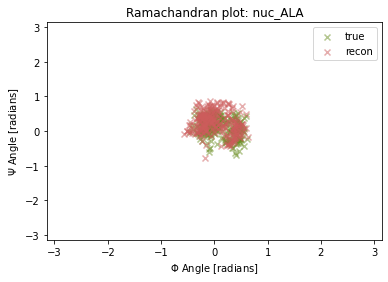

In [590]:
draw_ram(nuc_results['true_traj'], nuc_results['recon_traj'],'nuc_ALA')

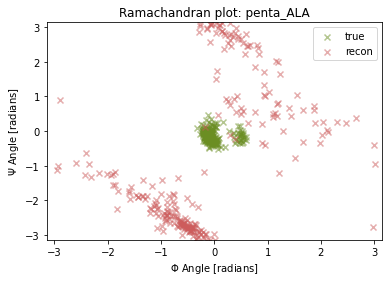

In [572]:
draw_ram(npenta_results['true_traj'], npenta_results['recon_traj'],'penta_ALA')

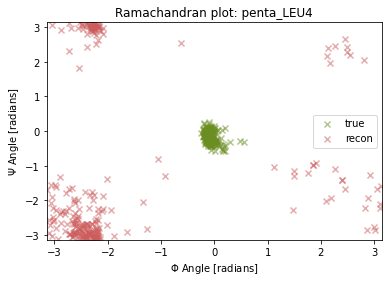

In [571]:
draw_ram(npenta_results['true_traj'], npenta_results['recon_traj'],'penta_LEU4')

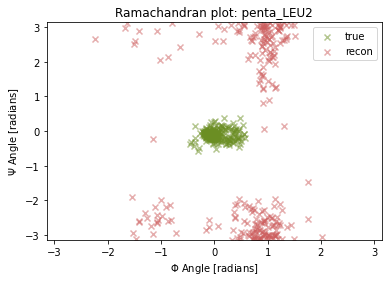

In [570]:
draw_ram(npenta_results['true_traj'], npenta_results['recon_traj'],'penta_LEU2')

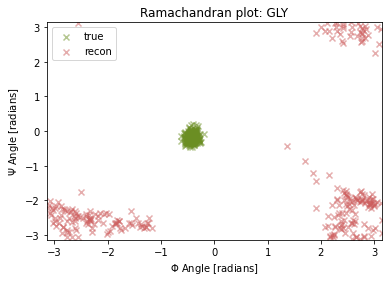

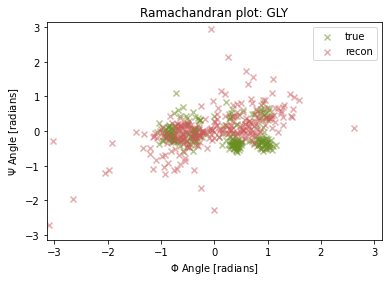

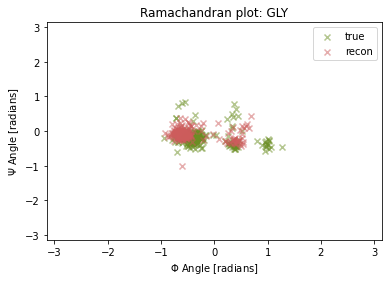

In [518]:
# partialchig
res= 'GLY'
draw_ram(pchig1_results['true_traj'], pchig1_results['recon_traj'], res)
draw_ram(pchig2_results['true_traj'], pchig2_results['recon_traj'], res)
draw_ram(pchig3_results['true_traj'], pchig3_results['recon_traj'], res)

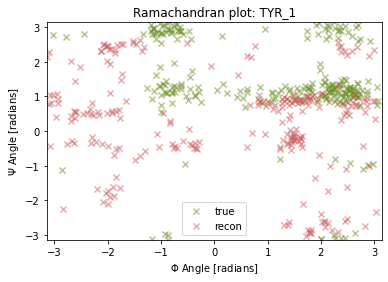

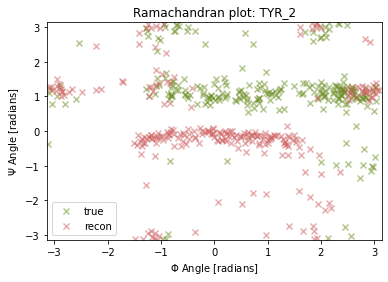

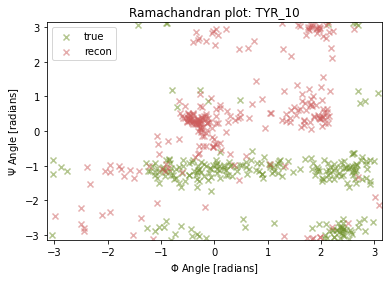

In [529]:
# partialchig
draw_ram(pchig3_results['true_traj'], pchig3_results['recon_traj'], 'TYR_1')
draw_ram(pchig3_results['true_traj'], pchig3_results['recon_traj'], 'TYR_2')
draw_ram(pchig3_results['true_traj'], pchig3_results['recon_traj'], 'TYR_10')

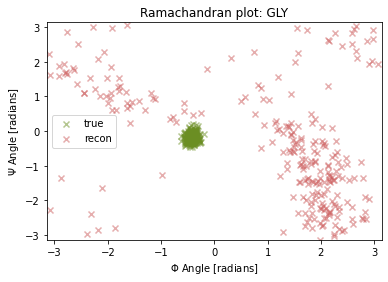

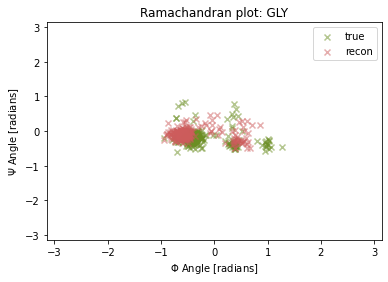

In [605]:
draw_ram(allchig1_results['true_traj'], allchig1_results['recon_traj'], 'GLY')
draw_ram(allchig3_results['true_traj'], allchig3_results['recon_traj'], 'GLY')

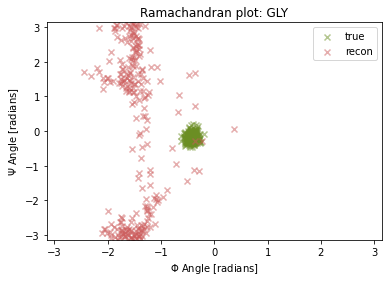

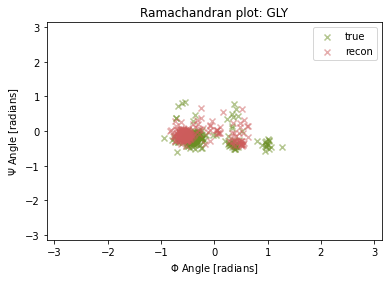

In [604]:
draw_ram(chig1_results['true_traj'], chig1_results['recon_traj'], 'GLY')
draw_ram(chig3_results['true_traj'], chig3_results['recon_traj'], 'GLY')

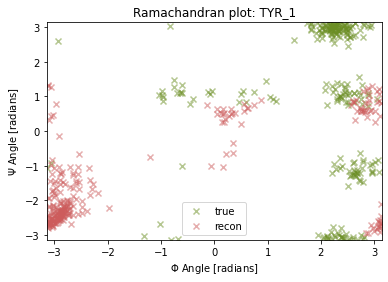

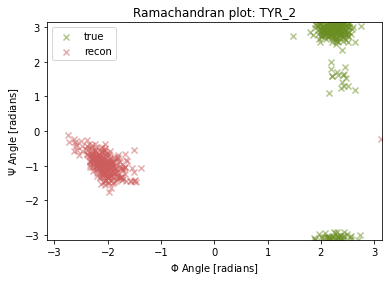

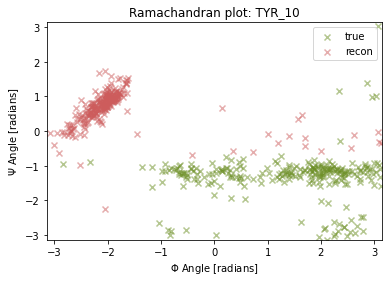

In [544]:
# fullchig
draw_ram(chig1_results['true_traj'], chig1_results['recon_traj'], 'TYR_1')
draw_ram(chig1_results['true_traj'], chig1_results['recon_traj'], 'TYR_2')
draw_ram(chig1_results['true_traj'], chig1_results['recon_traj'], 'TYR_10')

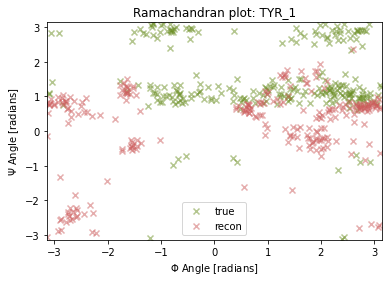

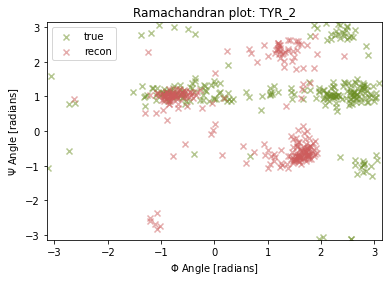

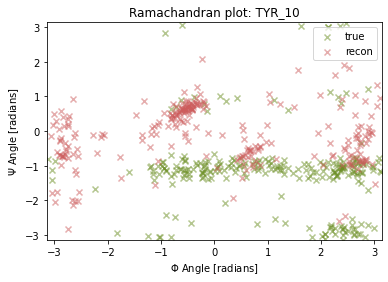

In [543]:
# fullchig
draw_ram(chig2_results['true_traj'], chig2_results['recon_traj'], 'TYR_1')
draw_ram(chig2_results['true_traj'], chig2_results['recon_traj'], 'TYR_2')
draw_ram(chig2_results['true_traj'], chig2_results['recon_traj'], 'TYR_10')

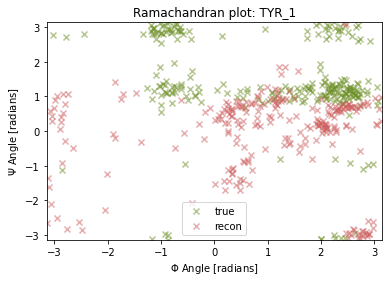

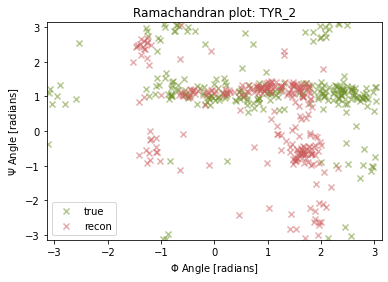

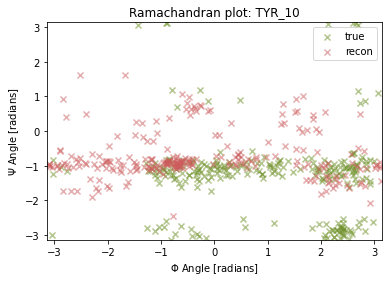

In [528]:
# fullchig
draw_ram(chig3_results['true_traj'], chig3_results['recon_traj'], 'TYR_1')
draw_ram(chig3_results['true_traj'], chig3_results['recon_traj'], 'TYR_2')
draw_ram(chig3_results['true_traj'], chig3_results['recon_traj'], 'TYR_10')

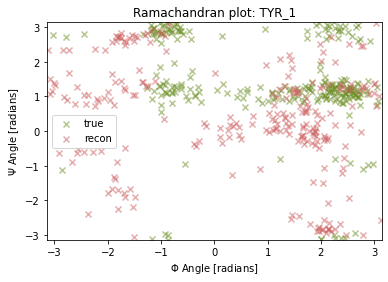

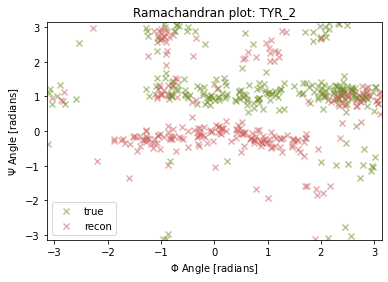

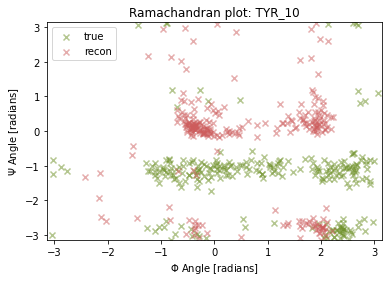

In [539]:
# multichig
draw_ram(chig3_results['true_traj'], chig3_results['recon_traj'], 'TYR_1')
draw_ram(chig3_results['true_traj'], chig3_results['recon_traj'], 'TYR_2')
draw_ram(chig3_results['true_traj'], chig3_results['recon_traj'], 'TYR_10')

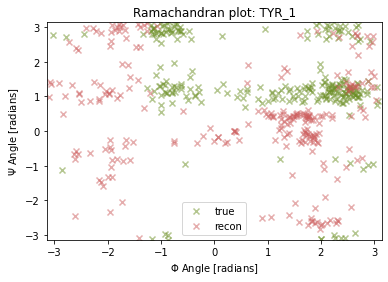

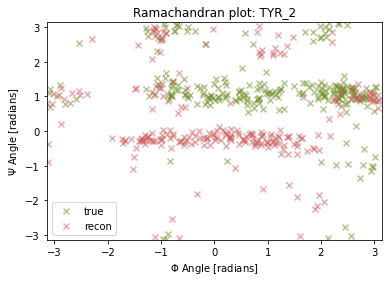

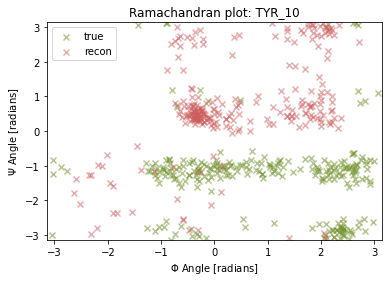

In [525]:
# ogpchig
draw_ram(ogpchig3_results['true_traj'], ogpchig3_results['recon_traj'], 'TYR_1')
draw_ram(ogpchig3_results['true_traj'], ogpchig3_results['recon_traj'], 'TYR_2')
draw_ram(ogpchig3_results['true_traj'], ogpchig3_results['recon_traj'], 'TYR_10')

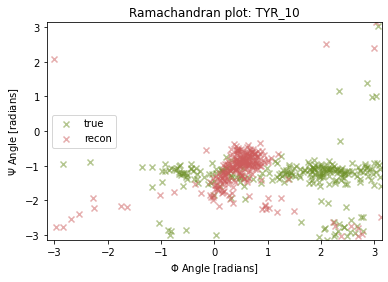

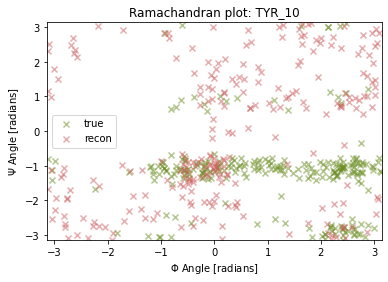

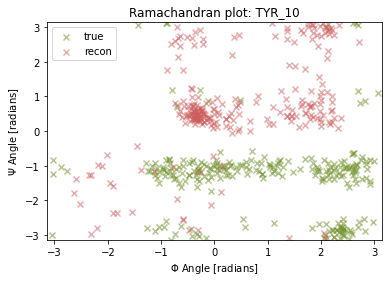

In [524]:
# ogpchig
res= 'TYR_10'
draw_ram(ogpchig1_results['true_traj'], ogpchig1_results['recon_traj'], res)
draw_ram(ogpchig2_results['true_traj'], ogpchig2_results['recon_traj'], res)
draw_ram(ogpchig3_results['true_traj'], ogpchig3_results['recon_traj'], res)

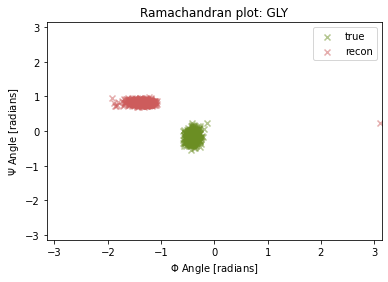

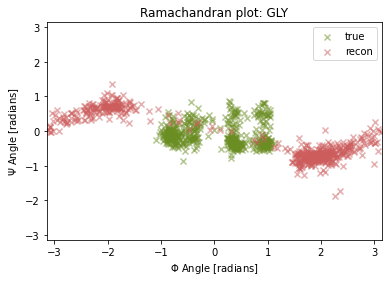

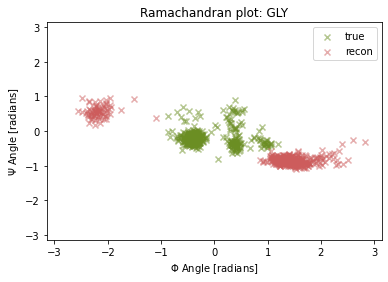

In [516]:
# ogchig
res= 'GLY'
draw_ram(ogchig1_results['true_traj'], ogchig1_results['recon_traj'], res)
draw_ram(ogchig2_results['true_traj'], ogchig2_results['recon_traj'], res)
draw_ram(ogchig3_results['true_traj'], ogchig3_results['recon_traj'], res)

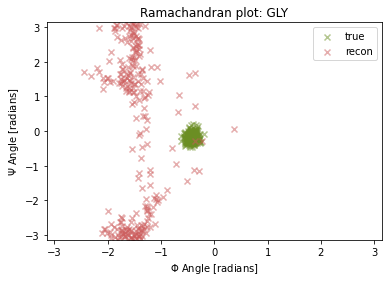

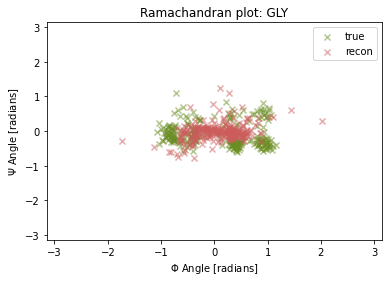

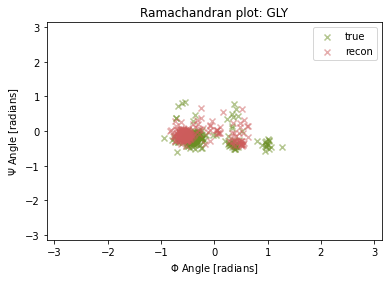

In [515]:
# fullchig
res = 'GLY'
draw_ram(chig1_results['true_traj'], chig1_results['recon_traj'], res)
draw_ram(chig2_results['true_traj'], chig2_results['recon_traj'], res)
draw_ram(chig3_results['true_traj'], chig3_results['recon_traj'], res)

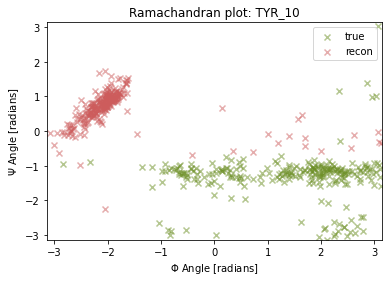

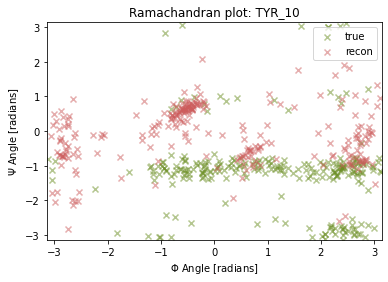

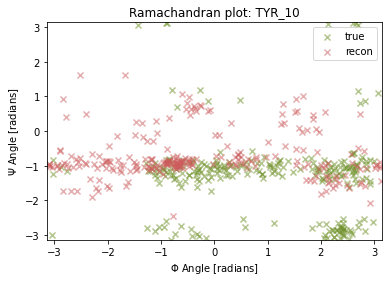

In [503]:
# fullchig
draw_ram(chig1_results['true_traj'], chig1_results['recon_traj'], 'TYR_10')
draw_ram(chig2_results['true_traj'], chig2_results['recon_traj'], 'TYR_10')
draw_ram(chig3_results['true_traj'], chig3_results['recon_traj'], 'TYR_10')

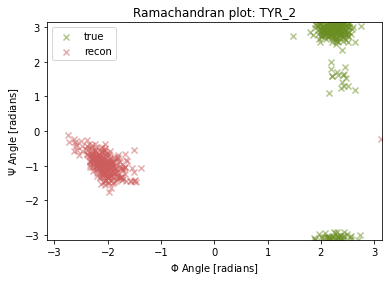

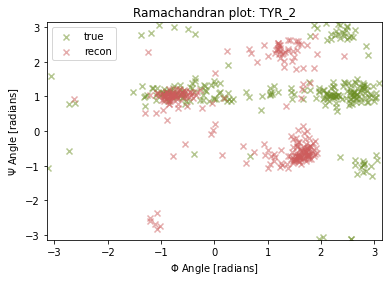

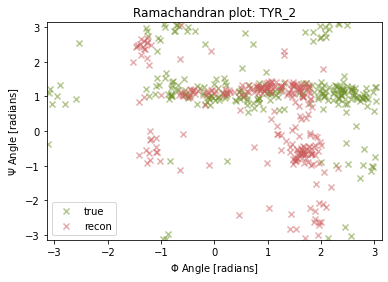

In [502]:
# fullchig
draw_ram(chig1_results['true_traj'], chig1_results['recon_traj'], 'TYR_2')
draw_ram(chig2_results['true_traj'], chig2_results['recon_traj'], 'TYR_2')
draw_ram(chig3_results['true_traj'], chig3_results['recon_traj'], 'TYR_2')

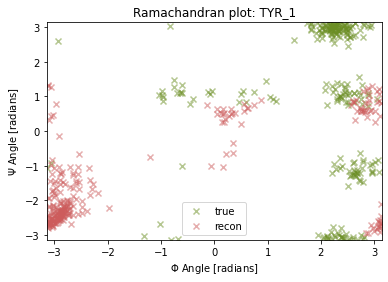

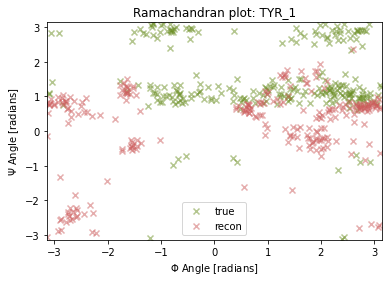

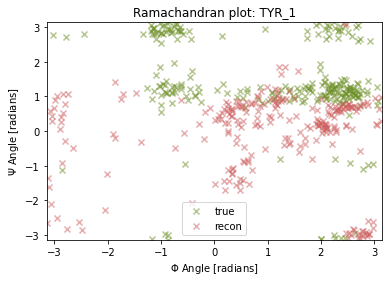

In [501]:
# fullchig
draw_ram(chig1_results['true_traj'], chig1_results['recon_traj'], 'TYR_1')
draw_ram(chig2_results['true_traj'], chig2_results['recon_traj'], 'TYR_1')
draw_ram(chig3_results['true_traj'], chig3_results['recon_traj'], 'TYR_1')

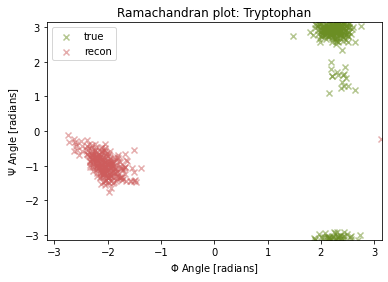

In [496]:

draw_ram(chig1_results['true_traj'], chig1_results['recon_traj'])

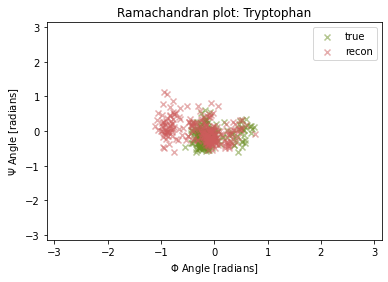

In [418]:
draw_ram(chig3_results['true_traj'], chig3_results['recon_traj'])

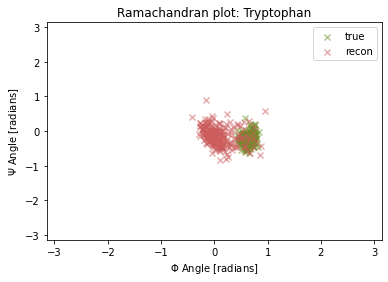

In [419]:
draw_ram(chig1_results['true_traj'], chig1_results['recon_traj'])

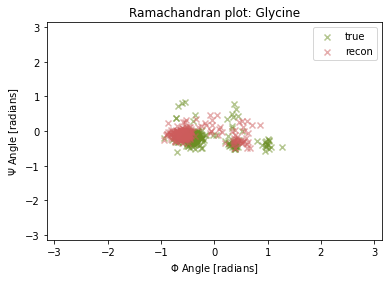

In [274]:
draw_ram(chig3_results['true_traj'], chig3_results['recon_traj'])

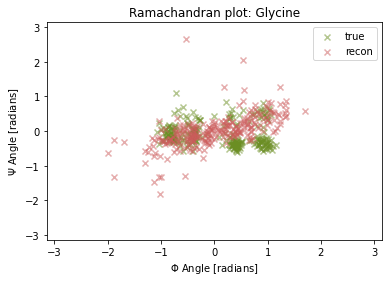

In [286]:
draw_ram(chig2_results['true_traj'], chig2_results['recon_traj'])

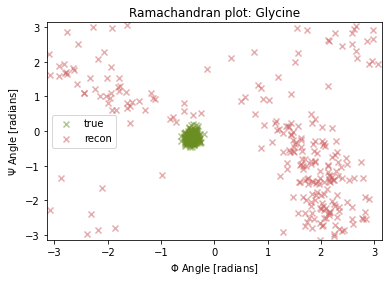

In [275]:
draw_ram(chig1_results['true_traj'], chig1_results['recon_traj'])

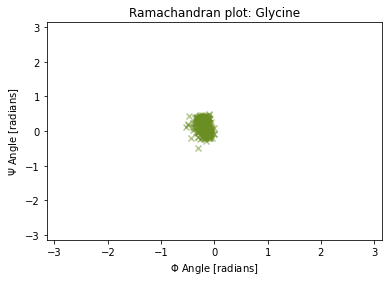

In [269]:
draw_ram(chig1_results['true_traj'])

**train only with chig partial**

In [519]:
# ogpartialchig
exp_path = './chig_partial_3_og_09-19_alpha_sample_ndata5000_N5_test_chignolin_1/'
ogpchig1_results = load_test_results(exp_path, top, features, tica_obj)
exp_path = './chig_partial_3_og_09-19_alpha_sample_ndata5000_N5_test_chignolin_2'
ogpchig2_results = load_test_results(exp_path, top, features, tica_obj)
exp_path = './chig_partial_3_og_09-19_alpha_sample_ndata5000_N5_test_chignolin_3'
ogpchig3_results = load_test_results(exp_path, top, features, tica_obj)

In [517]:
# partialchig
exp_path = './chig_partial_3_09-17_alpha_sample_ndata5000_N5_test_chignolin_1/'
pchig1_results = load_test_results(exp_path, top, features, tica_obj)
exp_path = './chig_partial_3_09-17_alpha_sample_ndata5000_N5_test_chignolin_2'
pchig2_results = load_test_results(exp_path, top, features, tica_obj)
exp_path = './chig_partial_3_09-17_alpha_sample_ndata5000_N5_test_chignolin_3'
pchig3_results = load_test_results(exp_path, top, features, tica_obj)

In [253]:
print("In-class rmsd: ", chig3_results['rmsd'].mean())
print("Out-of-class rmsd: ", chig1_results['rmsd'].mean())

In-class rmsd:  0.14316775
Out-of-class rmsd:  0.24077006


In [277]:
all_results = combine_results([chig1_results, chig2_results, chig3_results])

/tmp/ipykernel_31738/3417305845.py:11: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


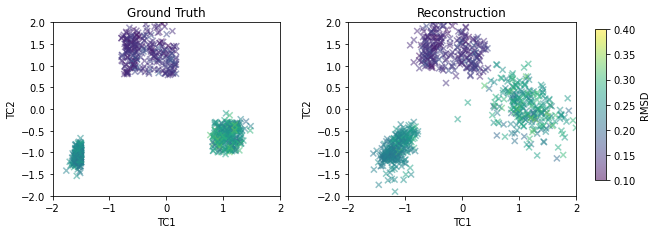

In [238]:
plot_results(all_results[2], all_results[3], all_results[4])

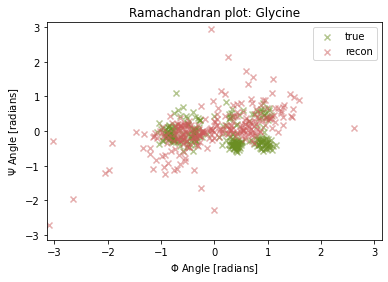

In [288]:
draw_ram(chig2_results['true_traj'], chig2_results['recon_traj'])

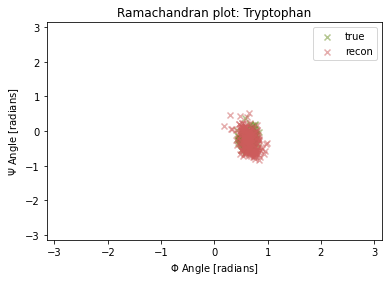

In [421]:
draw_ram(chig1_results['true_traj'], chig1_results['recon_traj'])

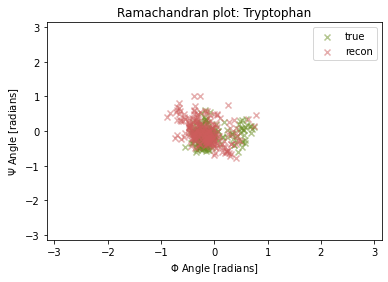

In [422]:
draw_ram(chig3_results['true_traj'], chig3_results['recon_traj'])

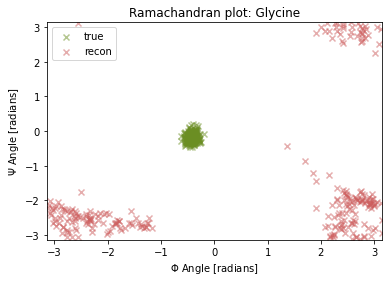

In [279]:
draw_ram(chig1_results['true_traj'], chig1_results['recon_traj'])

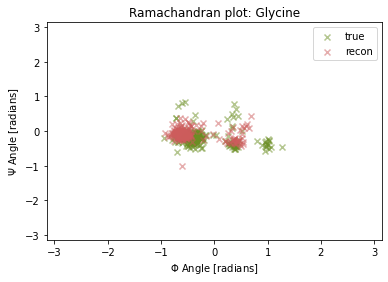

In [278]:
draw_ram(chig3_results['true_traj'], chig3_results['recon_traj'])

In [256]:
v = view_traj(chig3_results['true_traj'][0])
v.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [257]:
v = view_traj(chig3_results['recon_traj'][0])
v.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [258]:
v = view_traj(chig1_results['recon_traj'][0])
v.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [259]:
v = view_traj(chig1_results['true_traj'][0])
v.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### residue prior transferability

In [ ]:
penta_top = 

**fs+coil**

In [ ]:
exp_path = './chig_multiCGVAE_09-16_alpha_sample_ndata5000_N10_test_chignolin_3'
all_results = load_test_results(exp_path, penta_top, penta_features, penta_tica_obj)

In [ ]:
plot_results(all_results['out_recon'], all_results['out_true'], all_results['rmsd'])

**fs**

In [ ]:
exp_path = './chig_multiCGVAE_09-16_alpha_sample_ndata5000_N10_test_chignolin_3'
all_results = load_test_results(exp_path, penta_top, penta_features, penta_tica_obj)

In [ ]:
plot_results(all_results['out_recon'], all_results['out_true'], all_results['rmsd'])

**penta**

In [ ]:
exp_path = './chig_multiCGVAE_09-16_alpha_sample_ndata5000_N10_test_chignolin_3'
all_results = load_test_results(exp_path, penta_top, penta_features, penta_tica_obj)

In [ ]:
plot_results(all_results['out_recon'], all_results['out_true'], all_results['rmsd'])

## chignolin prep

In [30]:
atomic_nums, protein_index = get_atomNum(all_traj[0])
top = all_traj[0].top.subset(protein_index)

In [73]:
chig1_results['rmsd']

2.4632885

In [39]:
print("Out-of-class rmsd: ", chig1_results['rmsd'].mean())

Out-of-class rmsd:  2.4632885


/tmp/ipykernel_31738/516674341.py:12: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


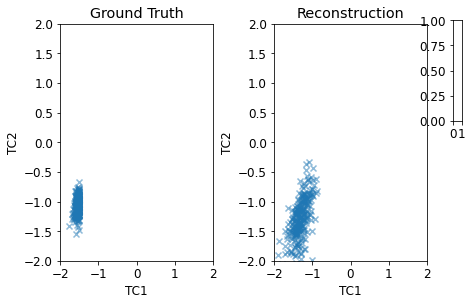

In [46]:
plot_results(chig1_results['out_recon'], chig1_results['out_true'], chig1_results['rmsd'])

In [48]:
m_view = ng.show_mdtraj(chig1_results['true_traj'].center_coordinates())
m_view

NGLWidget(max_frame=249)

In [67]:
chig1_results['recon_traj'][0].save_pdb('./tmp/00.pdb')

In [71]:
chig1_results['recon_traj'][0].save_pdb('./tmp/01.pdb')

In [61]:
import py3Dmol as p3D

In [104]:
def view_traj(traj):
    traj.save_pdb('./tmp/tmp.pdb')
    view = p3D.view(js='https://3dmol.org/build/3Dmol.js',)
    view.addModel(open('./tmp/tmp.pdb','r').read(),'pdb')
    view.addStyle(
                {'stick':{'colorscheme':'greenCarbon','radius':0.3}})
    view.setViewStyle({'style':'outline','color':'black','width':0.1})

    view.zoomTo()
    return view


In [72]:
view = p3D.view(js='https://3dmol.org/build/3Dmol.js',)
view.addModel(open('./tmp/01.pdb','r').read(),'pdb')
view.addStyle(
            {'stick':{'colorscheme':'greenCarbon','radius':0.3}})
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [70]:
view = p3D.view(js='https://3dmol.org/build/3Dmol.js',)
view.addModel(open('./tmp/00.pdb','r').read(),'pdb')
view.addStyle(
            {'stick':{'colorscheme':'greenCarbon','radius':0.3}})
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### Functions

In [578]:
def load_test_results_only(exp_path, top):
    with open(os.path.join(exp_path, f'fold0/true_xyz.pkl'),'rb') as fh:
        true_xyz = pickle.load(fh)#.reshape(-1, top.n_atoms, 3)
    with open(os.path.join(exp_path, f'fold0/recon_xyz.pkl'),'rb') as fh:
        recon_xyz = pickle.load(fh)#.reshape(-1, top.n_atoms, 3)
    with open(os.path.join(exp_path, f'fold0/rmsd.pkl'),'rb') as fh:
        result = pickle.load(fh)
    
#     print(result)
#     result = result['test_rmsd']
    true_xyz /= 10
    recon_xyz /= 10
    
    true_traj = md.Trajectory(true_xyz, top)
    recon_traj = md.Trajectory(recon_xyz, top)
    
    result /= 10
    return {'true_traj': true_traj, 'recon_traj':recon_traj,'rmsd': result}
    

In [508]:
def load_test_results(exp_path, top, features, tica_obj):
    with open(os.path.join(exp_path, f'fold0/true_xyz.pkl'),'rb') as fh:
        true_xyz = pickle.load(fh)#.reshape(-1, top.n_atoms, 3)
    with open(os.path.join(exp_path, f'fold0/recon_xyz.pkl'),'rb') as fh:
        recon_xyz = pickle.load(fh)#.reshape(-1, top.n_atoms, 3)
    with open(os.path.join(exp_path, f'fold0/rmsd.pkl'),'rb') as fh:
        result = pickle.load(fh)
    
#     print(result)
#     result = result['test_rmsd']
    true_xyz /= 10
    recon_xyz /= 10
    
    true_traj = md.Trajectory(true_xyz, top)
    recon_traj = md.Trajectory(recon_xyz, top)
    feat_true = features.transform(true_traj)
    feat_recon = features.transform(recon_traj)
    out_true = tica_obj.transform(feat_true)
    out_recon = tica_obj.transform(feat_recon)
    result /= 10
    return {'true_traj': true_traj, 'recon_traj':recon_traj, 'out_true':out_true, 'out_recon':out_recon,
            'rmsd': result}
    

In [237]:
def combine_results(result_dics):
    chig_recon_xyz = np.vstack([dic['recon_traj'].xyz for dic in result_dics])
    chig_true_xyz = np.vstack([dic['true_traj'].xyz for dic in result_dics])
    chig_recon_red = np.vstack([dic['out_recon'][:, :2] for dic in result_dics])
    chig_true_red = np.vstack([dic['out_true'][:, :2] for dic in result_dics])
    rmsd = np.concatenate([dic['rmsd'] for dic in result_dics], -1)
    return chig_recon_xyz, chig_true_xyz, chig_recon_red, chig_true_red, rmsd
    
def plot_results(chig_recon, chig_true, rmsd):
    fig, axes = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(8, 3))
    fig.tight_layout()

    im = axes[0].scatter(chig_true[:, 0], chig_true[:, 1], marker='x', alpha=0.5, c=rmsd, vmin=0.1, vmax=0.4)
    im = axes[1].scatter(chig_recon[:, 0], chig_recon[:, 1], marker='x', alpha=0.5, c=rmsd, vmin=0.1, vmax=0.4)
#     pos1=fig.add_axes([1,0.6,0.02,0.35])
    pos1=fig.add_axes([1,0.2,0.02,0.7])
    cbar = fig.colorbar(im, cax=pos1)
    cbar.set_label('RMSD')

    for ax in axes:    
        ax.set_xlim([-2,2])
        ax.set_ylim([-2,2])
        ax.set_xlabel(r'TC1')
        ax.set_ylabel(r'TC2')
    axes[0].set_title('Ground Truth')
    axes[1].set_title('Reconstruction')
        
#     ax[0].text(-1.7, -1, '1', fontsize=14, color='white')
#     ax[0].text(1, -0.7, '2', fontsize=14, color='white')

    plt.subplots_adjust(wspace=0.3)